# Introduction
## Load libs

In [1]:
import numpy as np
import pandas as pd
import random
from os import listdir
import math
import tensorflow as tf

import csv

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from sklearn.utils import shuffle

from fastai.vision import *
from fastai.metrics import error_rate # 1 - accuracy

import sklearn.model_selection
from sklearn.metrics import roc_curve, auc

## Paths

In [2]:
TRAIN_PATH = "../input/train"
TRAIN_LABEL_PATH = "../input/train_labels.csv"
TEST_ORIG_PATH = "../input/test"

SUB_PATH = "./submissions/"
MODELS_PATH = "./models/"

## Labels 

In [3]:
labels = pd.read_csv(TRAIN_LABEL_PATH, index_col = False, dtype = {"has_cactus": np.str})
labels["id"] += ".tif"
labels.head()

id  label
0  f38a6374c348f90b587e046aac6079959adf3835.tif      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif      1
2  755db6279dae599ebb4d39a9123cce439965282d.tif      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif      0
4  068aba587a4950175d04c680d38943fd488d6a9d.tif      0

## Data frames

In [4]:
# df_train, df_val = sklearn.model_selection.train_test_split(labels, test_size = 0.05)

df_test = pd.DataFrame(listdir(TEST_ORIG_PATH))
df_test.columns = ["id"]
# df_test["path"] = f"{TEST_ORIG_PATH}{df_test['id']}"
df_test.head()

id
0  485b548a7ee70df49fe7cab6d7062fb8d8f172aa.tif
1  0a13be637bd66856953494747e1a56e11e394acc.tif
2  1d19c0a74340c60c31b677a0032e710886645bc6.tif
3  f45110c8ce329fc4292c2dfb93f1bc73b31d0919.tif
4  e07ddd315e3037431689b18b3631c756a7220102.tif

# Parameters

In [5]:
im_size = 128
batch_size = 32
epochs = 30

# num_train_samples = len(df_train)
# num_val_samples = len(df_val)
# train_steps = math.ceil(num_train_samples/batch_size)
# val_steps = math.ceil(num_val_samples/batch_size)

## Transforms 

In [6]:
# Applying Data augmentation
trfm = get_transforms(do_flip=True, flip_vert=True, max_rotate=10.0, max_zoom=1.1, max_lighting=0.2, max_warp=0.2, p_affine=0.75, p_lighting=0.75)

# Get Data

In [7]:
test_img = ImageList.from_df(df_test, path=TEST_ORIG_PATH)
train_img = (ImageList.from_df(labels, path=TRAIN_PATH)
        .split_by_rand_pct(0.01)
        .label_from_df()
        .add_test(test_img)
        .transform(trfm, size=im_size)
        .databunch(path='.', bs=batch_size, device= torch.device('cuda:0'))
        .normalize(imagenet_stats)
       )

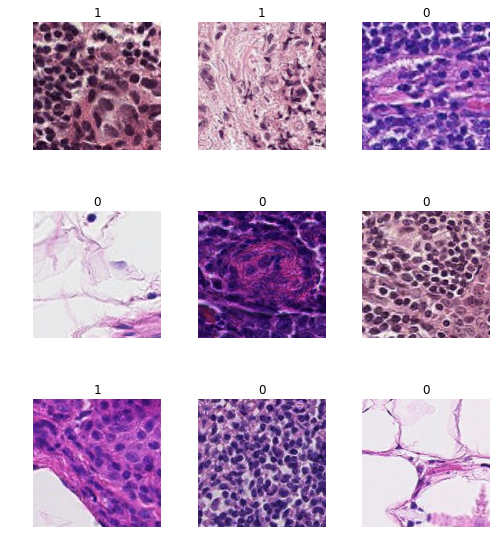

In [8]:
train_img.show_batch(rows=3, figsize=(7, 8))

# Model
## Create

In [9]:
def getLearner():
    return cnn_learner(train_img, models.densenet169, pretrained=True, metrics=[error_rate, accuracy])

In [10]:
# create cnn with the vgg16 architecture
learner = getLearner()

Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /tmp/.torch/models/densenet169-b2777c0a.pth
57365526it [00:02, 28327866.36it/s]


## Find LR 

In [11]:
lrs = []
losses = []
wds = []
iter_count = 600

# WEIGHT DECAY = 1e-6
learner.lr_find(wd=1e-6, num_it=iter_count)
lrs.append(learner.recorder.lrs)
losses.append(learner.recorder.losses)
wds.append('1e-6')
learner = getLearner() #reset learner - this gets more consistent starting conditions

# WEIGHT DECAY = 1e-4
learner.lr_find(wd=1e-4, num_it=iter_count)
lrs.append(learner.recorder.lrs)
losses.append(learner.recorder.losses)
wds.append('1e-4')
learner = getLearner() #reset learner - this gets more consistent starting conditions

# WEIGHT DECAY = 1e-2
learner.lr_find(wd=1e-2, num_it=iter_count)
lrs.append(learner.recorder.lrs)
losses.append(learner.recorder.losses)
wds.append('1e-2')
learner = getLearner() #reset learner

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


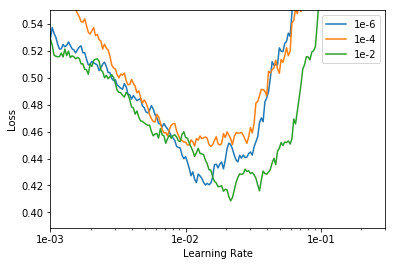

In [12]:
# Plot weight decays
_, ax = plt.subplots(1,1)
min_y = 0.5
max_y = 0.55
for i in range(len(losses)):
    ax.plot(lrs[i], losses[i])
    min_y = min(np.asarray(losses[i]).min(), min_y)
ax.set_ylabel("Loss")
ax.set_xlabel("Learning Rate")
ax.set_xscale('log')
#ax ranges may need some tuning with different model architectures 
ax.set_xlim((1e-3,3e-1))
ax.set_ylim((min_y - 0.02,max_y))
ax.legend(wds)
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))

In [13]:
try:
    learner = learner.load("fast_ai_model_1")
    print("Loaded model.")
except:
    print("Training model. === Stage 1")
    max_lr = 2e-2
    wd = 1e-4
    # 1cycle policy
    learner.fit_one_cycle(cyc_len=8, max_lr=max_lr, wd=wd)
    learner.save("fast_ai_model_1")

Training model. === Stage 1


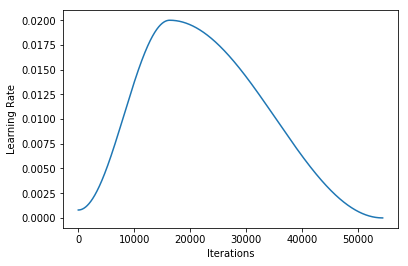

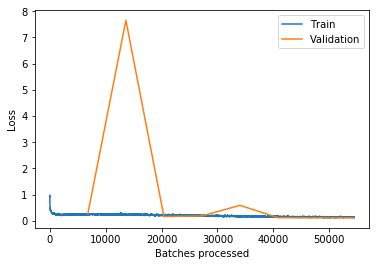

In [14]:
learner.recorder.plot_lr()
learner.recorder.plot_losses()

# Evaluate stage 1 model
## Confusion Matrix

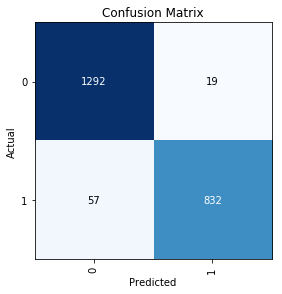

In [15]:
interp = ClassificationInterpretation.from_learner(learner)

interp.plot_confusion_matrix(title = "Confusion Matrix")

## Accuracy

In [16]:
preds, y, loss = learner.get_preds(with_loss=True)
acc = accuracy(preds, y)
print('The accuracy is {0} %.'.format(acc*100))

The accuracy is 96.54544830322266 %.


## ROC and AUC

In [17]:
# probs from log preds
probs = np.exp(preds[:,1])
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y, probs, pos_label=1)

# Compute ROC area
roc_auc = auc(fpr, tpr)
print('ROC area is {0}'.format(roc_auc))

ROC area is 0.9900590229424984


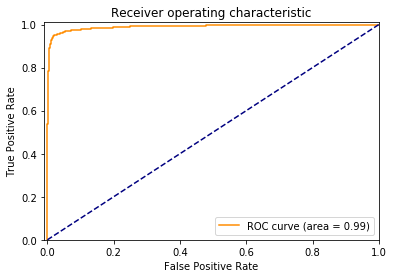

In [18]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

# Finetune stage 1

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


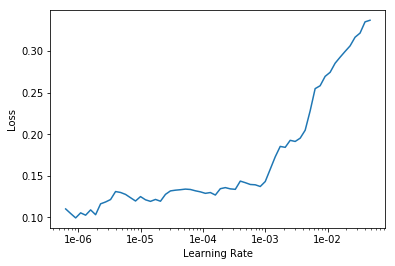

In [19]:
learner.load("fast_ai_model_1")

# unfreeze and run learning rate finder again
learner.unfreeze()
learner.lr_find(wd=wd)

# plot learning rate finder results
learner.recorder.plot()

In [20]:
learner.fit_one_cycle(cyc_len=5, max_lr=slice(4e-5,4e-4))
learner.save("fast_ai_model_2")

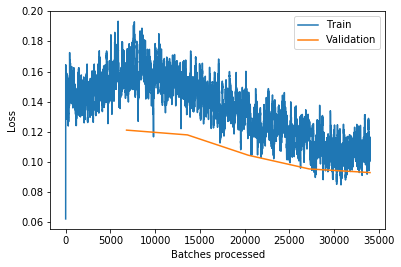

In [21]:
learner.recorder.plot_losses()

# Evaluate stage 2

## Confusion matrix

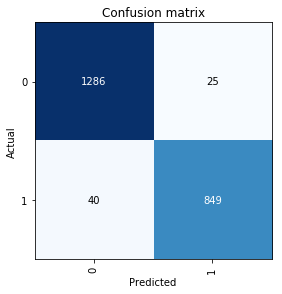

In [22]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(title='Confusion matrix')

## Accuracy

In [23]:
preds, y, loss = learner.get_preds(with_loss=True)
acc = accuracy(preds, y)
print('The accuracy is {0} %.'.format(acc*100))

The accuracy is 97.04545593261719 %.


## ROC and AUC

In [24]:
# probs from log preds
probs = np.exp(preds[:,1])
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y, probs, pos_label=1)

# Compute ROC area
roc_auc = auc(fpr, tpr)
print('ROC area is {0}'.format(roc_auc))

ROC area is 0.9923091707358089


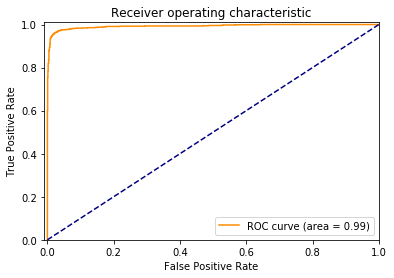

In [25]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

# Predict

In [26]:
preds,_ = learner.get_preds(ds_type=DatasetType.Test)

In [27]:
df_test["label"] = preds.numpy()[:, 0]
df_test["id"] = df_test["id"].str.replace(".tif","")
df_test.head()

id     label
0  485b548a7ee70df49fe7cab6d7062fb8d8f172aa  0.999693
1  0a13be637bd66856953494747e1a56e11e394acc  0.894817
2  1d19c0a74340c60c31b677a0032e710886645bc6  0.953151
3  f45110c8ce329fc4292c2dfb93f1bc73b31d0919  0.000075
4  e07ddd315e3037431689b18b3631c756a7220102  0.988247

In [28]:
df_test.to_csv('submission.csv', index=False)